Graph Information:
Number of nodes: 5
Number of edges: 6


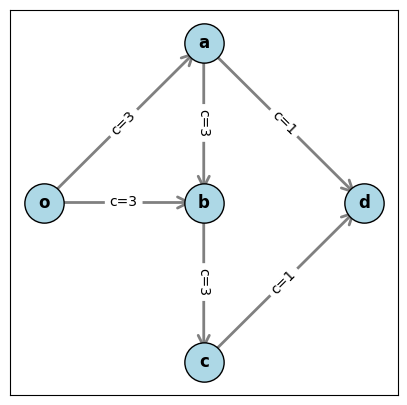

In [26]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the directed graph
G = nx.DiGraph()

# Add nodes
nodes = ["o", "a", "b", "c", "d"]
G.add_nodes_from(nodes)

# Add edges with capacities
edges = [
    ("o", "b", 3),  # o -> b with capacity 3
    ("o", "a", 3),  # o -> a with capacity 3
    ("a", "b", 3),  # a -> b with capacity 3
    ("b", "c", 3),  # b -> c with capacity 3
    ("c", "d", 1),  # c -> d with capacity 1
    ("a", "d", 1)   # a -> d with capacity 1
]

for u, v, cap in edges:
    G.add_edge(u, v, capacity=cap)

# Create visualization
plt.figure(figsize=(5, 5))

# Use a structured layout for better visualization
pos = {
    "o": (0, 2),    # source on left, at top level
    "a": (1, 3),    # top of vertical chain
    "b": (1, 2),    # middle of vertical chain (under a)
    "c": (1, 1),    # bottom of vertical chain (under b)
    "d": (2, 2)     # sink on right, at middle level
}

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                       arrowsize=20, arrowstyle='->', width=2)

# Add capacity labels
edge_labels = {(u, v): f'c={cap}' for u, v, cap in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Print graph information
print("Graph Information:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

# Build the graph
G = nx.DiGraph()
edges = [("o", "b", 3), ("o", "a", 3), ("a", "b", 3), 
         ("b", "c", 3), ("c", "d", 1), ("a", "d", 1)]
for u, v, cap in edges:
    G.add_edge(u, v, capacity=cap)

def find_all_cuts(G, source, sink):
    nodes = list(G.nodes())
    nodes.remove(source)
    nodes.remove(sink)
    
    cuts = []
    # Generate all possible subsets of remaining nodes
    for r in range(len(nodes) + 1):
        for subset in itertools.combinations(nodes, r):
            S = {source} | set(subset)
            T = set(G.nodes()) - S
            
            if sink in T:  # Valid cut
                cut_capacity = 0
                cut_edges = []
                for u in S:
                    for v in G.successors(u):
                        if v in T:
                            capacity = G[u][v]['capacity']
                            cut_capacity += capacity
                            cut_edges.append((u, v, capacity))
                cuts.append((S, T, cut_capacity, cut_edges))
    
    return cuts

# Find all cuts
all_cuts = find_all_cuts(G, "o", "d")
print("=== PART (a) ===")
print("All cuts and their capacities:")
for S, T, capacity, edges in sorted(all_cuts, key=lambda x: x[2]):
    print(f"S: {S}, Capacity: {capacity}")

min_cut = min(all_cuts, key=lambda x: x[2])
print(f"\nMinimum cut capacity: {min_cut[2]}")
print(f"Minimum capacity to remove for no feasible flow: {min_cut[2]}")

=== PART (a) ===
All cuts and their capacities:
S: {'c', 'o', 'a', 'b'}, Capacity: 2
S: {'o', 'a', 'b'}, Capacity: 4
S: {'c', 'o', 'b'}, Capacity: 4
S: {'o'}, Capacity: 6
S: {'o', 'b'}, Capacity: 6
S: {'o', 'a'}, Capacity: 7
S: {'c', 'o'}, Capacity: 7
S: {'c', 'o', 'a'}, Capacity: 8

Minimum cut capacity: 2
Minimum capacity to remove for no feasible flow: 2



=== PART (b) ===
Optimal capacity allocation:
x = 0: Throughput = 2, Allocation = {('o', 'b'): 0}
x = 1: Throughput = 3, Allocation = {('a', 'd'): 1}
x = 2: Throughput = 4, Allocation = {('a', 'd'): 2}
x = 3: Throughput = 4, Allocation = {('a', 'd'): 3}
x = 4: Throughput = 4, Allocation = {('a', 'd'): 4}
x = 5: Throughput = 4, Allocation = {('a', 'd'): 5}
x = 6: Throughput = 4, Allocation = {('a', 'd'): 6}
x = 7: Throughput = 4, Allocation = {('a', 'd'): 7}
x = 8: Throughput = 4, Allocation = {('a', 'd'): 8}
x = 9: Throughput = 4, Allocation = {('a', 'd'): 9}
x = 10: Throughput = 4, Allocation = {('a', 'd'): 10}


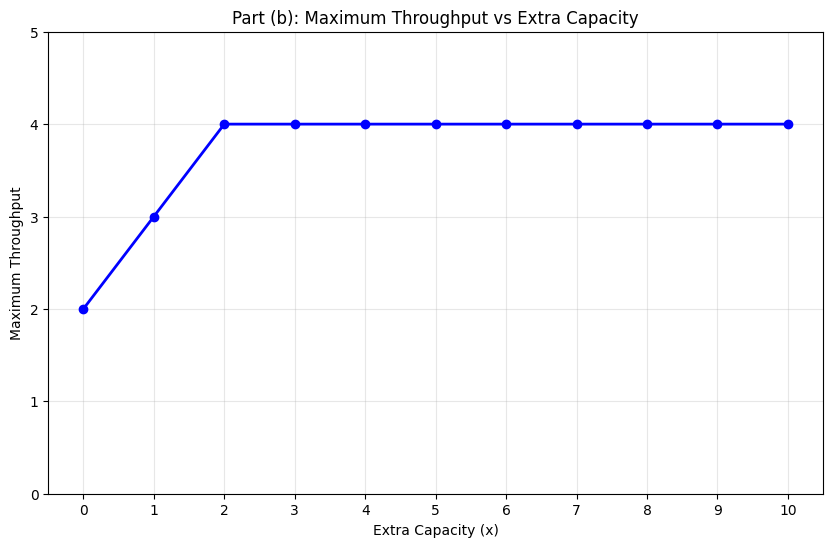

In [28]:
def optimize_throughput(G, source, sink, max_extra=10):
    results = []
    
    for x in range(max_extra + 1):
        max_throughput = 0
        best_allocation = {}
        
        # Try all possible allocations to single edges
        for edge in G.edges():
            temp_G = G.copy()
            temp_G[edge[0]][edge[1]]["capacity"] += x
            throughput = nx.maximum_flow_value(temp_G, source, sink)
            if throughput > max_throughput:
                max_throughput = throughput
                best_allocation = {edge: x}
        
        # If single edge doesn't help enough, try multiple edges
        if max_throughput == nx.maximum_flow_value(G, source, sink) and x > 0:
            # Find bottleneck edges in minimum cut
            min_cut_edges = min_cut[3]
            allocation = {}
            remaining = x
            for u, v, _ in min_cut_edges:
                if remaining > 0:
                    add_amount = min(1, remaining)  # Add 1 unit at a time
                    allocation[(u, v)] = add_amount
                    remaining -= add_amount
            
            temp_G = G.copy()
            for (u, v), add_cap in allocation.items():
                temp_G[u][v]["capacity"] += add_cap
            max_throughput = nx.maximum_flow_value(temp_G, source, sink)
            best_allocation = allocation
        
        results.append((x, max_throughput, best_allocation))
    
    return results

print("\n=== PART (b) ===")
results_b = optimize_throughput(G, "o", "d", 10)
print("Optimal capacity allocation:")
for x, throughput, allocation in results_b:
    print(f"x = {x}: Throughput = {throughput}, Allocation = {allocation}")

# Plot
x_vals = [r[0] for r in results_b]
y_vals = [r[1] for r in results_b]

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Extra Capacity (x)')
plt.ylabel('Maximum Throughput')
plt.title('Part (b): Maximum Throughput vs Extra Capacity')
plt.grid(True, alpha=0.3)
plt.xticks(x_vals)
plt.yticks(range(0, max(y_vals) + 2))
plt.show()


=== PART (c) ===
Analysis with new link e₈ (capacity = 1):

New link ('b', 'd'):
  x = 0: Throughput = 3
  x = 1: Throughput = 4
  x = 2: Throughput = 5
  x = 3: Throughput = 6
  x = 4: Throughput = 6
  x = 5: Throughput = 6

New link ('c', 'a'):
  x = 0: Throughput = 2
  x = 1: Throughput = 3
  x = 2: Throughput = 4
  x = 3: Throughput = 5
  x = 4: Throughput = 5
  x = 5: Throughput = 5

New link ('d', 'a'):
  x = 0: Throughput = 2
  x = 1: Throughput = 3
  x = 2: Throughput = 4
  x = 3: Throughput = 4
  x = 4: Throughput = 4
  x = 5: Throughput = 4

New link ('d', 'b'):
  x = 0: Throughput = 2
  x = 1: Throughput = 3
  x = 2: Throughput = 4
  x = 3: Throughput = 4
  x = 4: Throughput = 4
  x = 5: Throughput = 4

New link ('d', 'c'):
  x = 0: Throughput = 2
  x = 1: Throughput = 3
  x = 2: Throughput = 4
  x = 3: Throughput = 4
  x = 4: Throughput = 4
  x = 5: Throughput = 4

Best new link position: ('b', 'd')


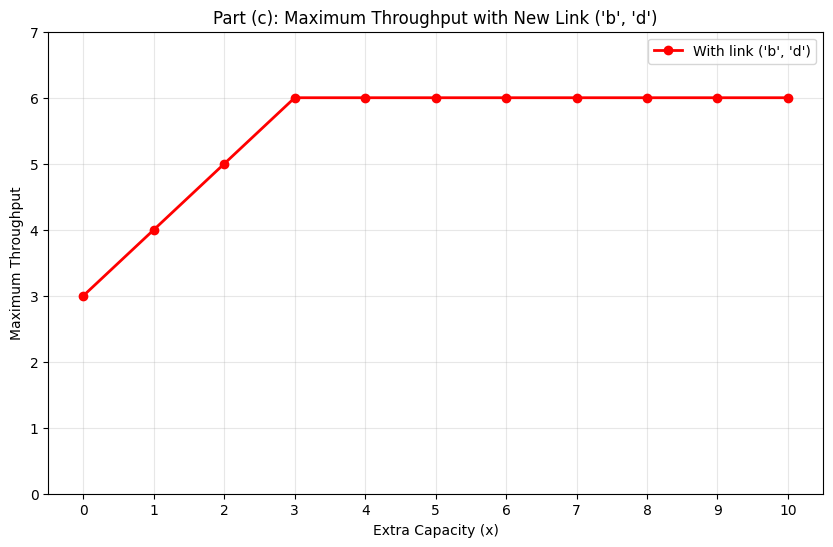

In [29]:
def analyze_with_new_link(G, source, sink, max_extra=10):
    # Possible new link positions
    possible_links = [("b", "d"), ("c", "a"), ("d", "a"), ("d", "b"), ("d", "c")]
    
    best_overall = None
    best_results = {}
    
    for new_link in possible_links:
        if new_link not in G.edges():
            temp_G = G.copy()
            temp_G.add_edge(new_link[0], new_link[1], capacity=1)
            
            results = []
            for x in range(max_extra + 1):
                max_throughput = nx.maximum_flow_value(temp_G, source, sink)
                best_allocation = {}
                
                # Try allocating to all edges
                for edge in temp_G.edges():
                    test_G = temp_G.copy()
                    test_G[edge[0]][edge[1]]["capacity"] += x
                    throughput = nx.maximum_flow_value(test_G, source, sink)
                    if throughput > max_throughput:
                        max_throughput = throughput
                        best_allocation = {edge: x}
                
                results.append((x, max_throughput, best_allocation))
            
            best_results[new_link] = results
            
            # Track best overall
            if best_overall is None or results[-1][1] > best_overall[-1][1]:
                best_overall = results
    
    return best_results, best_overall

print("\n=== PART (c) ===")
results_c, best_overall = analyze_with_new_link(G, "o", "d", 10)

print("Analysis with new link e₈ (capacity = 1):")
for new_link, results in results_c.items():
    print(f"\nNew link {new_link}:")
    for x, throughput, allocation in results[:6]:  # Show first 6 values
        print(f"  x = {x}: Throughput = {throughput}")

# Find best link
best_link = None
best_max_flow = 0
for new_link, results in results_c.items():
    if results[-1][1] > best_max_flow:
        best_max_flow = results[-1][1]
        best_link = new_link

print(f"\nBest new link position: {best_link}")

# Plot best result
plt.figure(figsize=(10, 6))
x_vals = [r[0] for r in best_overall]
y_vals = [r[1] for r in best_overall]
plt.plot(x_vals, y_vals, 'ro-', linewidth=2, markersize=6, label=f'With link {best_link}')
plt.xlabel('Extra Capacity (x)')
plt.ylabel('Maximum Throughput')
plt.title(f'Part (c): Maximum Throughput with New Link {best_link}')
plt.grid(True, alpha=0.3)
plt.xticks(x_vals)
plt.yticks(range(0, max(y_vals) + 2))
plt.legend()
plt.show()

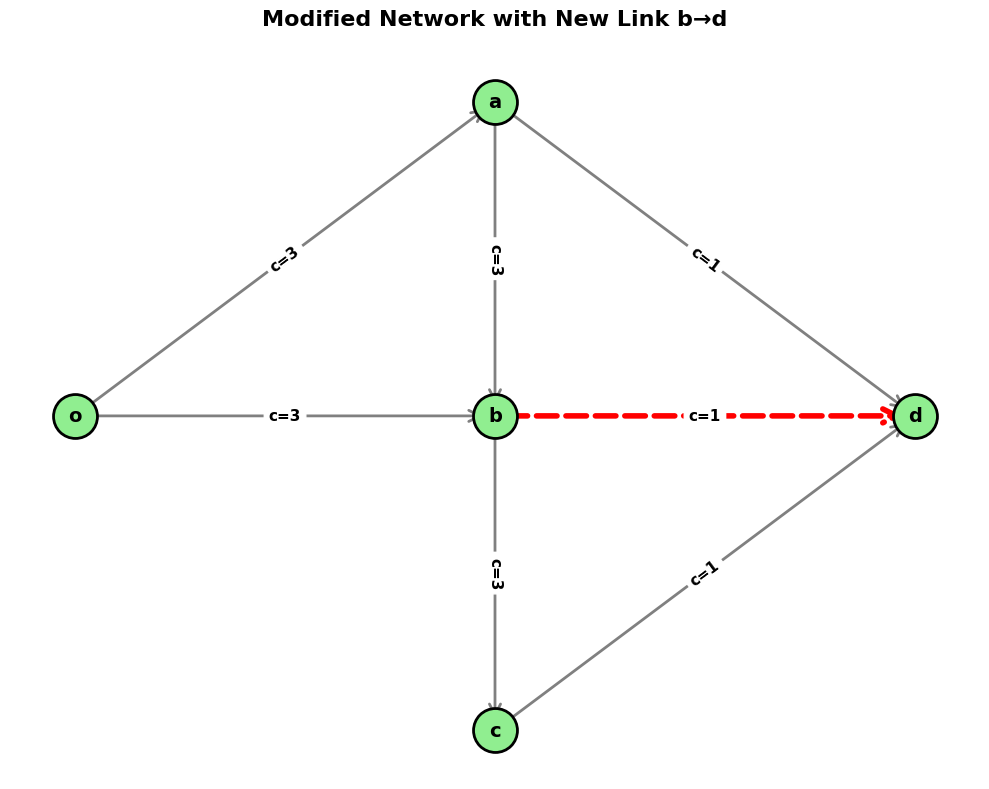

In [31]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the modified graph with new link b→d
G_new = nx.DiGraph()
edges = [("o", "b", 3), ("o", "a", 3), ("a", "b", 3), 
         ("b", "c", 3), ("c", "d", 1), ("a", "d", 1),
         ("b", "d", 1)]  # New link added
for u, v, cap in edges:
    G_new.add_edge(u, v, capacity=cap)

# Visualize only the modified network
pos = {
    "o": (0, 2),
    "a": (1, 3), 
    "b": (1, 2),
    "c": (1, 1),
    "d": (2, 2)
}

plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G_new, pos, node_size=1000, node_color='lightgreen', 
                      edgecolors='black', linewidths=2)
nx.draw_networkx_labels(G_new, pos, font_size=14, font_weight='bold')

# Draw edges - highlight the new link in red
for edge in G_new.edges():
    if edge == ("b", "d"):
        # New link - draw with red color and thicker line
        nx.draw_networkx_edges(G_new, pos, edgelist=[edge], edge_color='red', 
                              arrows=True, arrowsize=25, arrowstyle='->', 
                              width=4, style='dashed')
    else:
        # Original edges
        nx.draw_networkx_edges(G_new, pos, edgelist=[edge], edge_color='gray', 
                              arrows=True, arrowsize=20, arrowstyle='->', 
                              width=2)

# Add capacity labels
edge_labels = {(u, v): f'c={d["capacity"]}' for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=11, 
                            font_weight='bold')

plt.title("Modified Network with New Link b→d", fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()